# Topic classification


To classify submission that match one of three new topics Character1, Character2 and Character3 (examples below).

Along with the notebook, you'll find a dataset consisting of the following files:
- `imgs.tar`: a sample of images from DeviantArt
- `embeddings.npy`: CLIP embeddings for the same images
- `test_set.csv`: a set of test labels for 100 images for three different characters



In [1]:
import base64
import tarfile

import numpy as np
import pandas as pd
from PIL import Image

In [2]:
tar = tarfile.open('images.tar')

def get_image(idx):
    return Image.open(tar.extractfile(f"{idx}.jpg"))

def embed_image(idx):
    image_base64 = base64.b64encode(tar.extractfile(f"{idx}.jpg").read()).decode('ascii')
    return f'<img src="data:image/jpeg;base64,{image_base64}" />'

In [3]:
embeddings = np.load('image_embeddings.npy')
embeddings.shape

(92350, 512)

# Classifier

In [7]:
### To transfer images of each class to a separate directory
import os
import shutil
import random
from PIL import Image
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances,cosine_similarity
# import yaml

# def load_parameters(file_path='parameters.yml'):
#     with open(file_path, 'r') as yaml_file:
#         parameters = yaml.safe_load(yaml_file)
#     return parameters

def move_files_from_tar(image_names, target_dir, extension=".jpg"): #, prefix='image_', extension='.jpg'):
    """
    Transfer images from source directory to target directory with given names.
    
    Parameters:
        image_names (list): List of numbers representing image names.
        source_dir (str): Path to the source directory containing the images.
        target_dir (str): Path to the target directory where images will be transferred.
        prefix (str): Prefix to be added to the new image names (default is 'image_').
        extension (str): Extension of the image files (default is '.jpg').
    """

    # Open the tar file
    with tarfile.open("images.tar", 'r') as tar:
        # Check if destination file exists
        if os.path.exists(target_dir):
            # Delete the destination file
            shutil.rmtree(target_dir)
        
        os.makedirs(target_dir, exist_ok=True)
        
        existing_file = tar.getnames()
        # Loop through each image name
        for image_name in image_names:
            f_name = f'{image_name}{extension}'
            if f_name in existing_file:
                file_content = tar.extractfile(f_name)
                # Construct the destination path for the file
                destination_path = os.path.join(target_dir, f_name)
            
                # Copy the file content to the destination file
                with open(destination_path, 'wb') as dest_file:
                    shutil.copyfileobj(file_content, dest_file)
            else:
                print(f"Folder '{image_name}' not found in the tar file.")

def resize_images(input_folder, output_folder, target_size):
    """
    Resize all images in a folder while maintaining the aspect ratio and save them to another folder.
    
    Parameters:
        input_folder (str): Path to the input folder containing images.
        output_folder (str): Path to the output folder to save resized images.
        target_size (tuple): Target size (width, height) for the resized images.
    """
    # os.makedirs(output_folder, exist_ok=True)
    image_files = os.listdir(input_folder)
    
    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)
        
        # Open the image
        img = Image.open(input_path)
        
        # Resize while maintaining aspect ratio
        img.thumbnail(target_size, Image.LANCZOS)
        
        # Create a new image with the target size and paste the resized image onto it
        new_img = Image.new("RGB", target_size, (255, 255, 255))
        img_width, img_height = img.size
        left = (target_size[0] - img_width) // 2
        top = (target_size[1] - img_height) // 2
        new_img.paste(img, (left, top))
        # Save the resized image
        new_img.save(output_path)


In [8]:


min_class_size = min(label_0_indices.size,label_1_indices.size,label_2_indices.size)

def split_train_val(source_dir, train_dir, val_dir, num_val_images):
    """
    Split images from source directory into train and validation directories.
    
    Parameters:
        source_dir (str): Path to the source directory containing images.
        train_dir (str): Path to the train directory to create.
        val_dir (str): Path to the validation directory to create.
        val_split (float): Percentage of images to move to validation set (default is 0.2).
    """
    # Create train and val directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Get list of class folders in source directory
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    # Iterate over class folders
    for class_folder in classes:
        # Create class folders in train and val directories
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
        
        # Get list of image files in class folder
        images = [f for f in os.listdir(os.path.join(source_dir, class_folder)) if f.endswith('.jpg') or f.endswith('.png')]
        
        # Shuffle images
        random.shuffle(images)
        
        # Calculate number of images for validation set
        # num_val_images = int(len(images) * val_split)
        
        # Move images to train and val directories
        for i, image in enumerate(images):
            if i < num_val_images:
                shutil.copy(os.path.join(source_dir, class_folder, image), os.path.join(val_dir, class_folder, image))
            else:
                shutil.copy(os.path.join(source_dir, class_folder, image), os.path.join(train_dir, class_folder, image))


#### Weigth assignment based on class frequencies

In [9]:
import numpy as np

# Define paths to the training and validation data
train_data_dir = os.path.join("dataset", "train")
valid_data_dir = os.path.join("dataset", "val")


def get_number_of_file_each_folder(folder_path):
    file_frequencies = {}
    # Iterate over subfolders
    for subdir in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subdir)
        
        # Check if the subfolder is a directory
        if os.path.isdir(subfolder_path):
            # Count the number of files in the subfolder
            file_count = float(len(os.listdir(subfolder_path)))
            file_frequencies[int(os.path.basename(subfolder_path))]= file_count

    return file_frequencies

def calculate_class_weights(class_frequencies):
    # Assign weights inversely proportional to frequencies
    class_weights = len(class_frequencies) / (class_frequencies + 1e-6) #[x+1e-6 for x in class_frequencies] #(class_frequencies + [1e-6])
    
    # Normalize weights
    class_weights /= np.sum(class_weights)
    return class_weights

def calculate_class_weights_dict(wei):
    # # Assign weights inversely proportional to frequencies
    class_frequencies = np.array(list(wei)) # (train_data_dir).values()))
    class_weights = len(class_frequencies) / (class_frequencies + 1e-6) #[x+1e-6 for x in class_frequencies] #(class_frequencies + [1e-6])

    # Calculate the sum of values
    total = sum(wei.values())

    # Normalize values and create a new dictionary
    normalized_dict = {key: value/total for key, value in wei.items()}
    
    return normalized_dict

In [10]:
import os
import shutil
import random

def data_preparation(threshold):
    y = pd.DataFrame(embeddings.shape[0] *[3], columns=["label"])
    np.set_printoptions(threshold = np.inf)
    label_0_indices = np.where(cosine_similarity_df.iloc[0] > threshold)[0]
    y.loc[label_0_indices, 'label'] = 0
    label_1_indices = np.where(cosine_similarity_df.iloc[1] > threshold)[0]
    y.loc[label_1_indices, 'label'] = 1
    label_2_indices = np.where(cosine_similarity_df.iloc[2] > threshold)[0]
    y.loc[label_2_indices, 'label'] = 2
    print(label_0_indices.size)
    print(label_1_indices.size)
    print(label_2_indices.size)

    # move image files from .tar to destination path
    max_class_size = max(label_0_indices.size,label_1_indices.size,label_2_indices.size)
    min_class_size = min(label_0_indices.size,label_1_indices.size,label_2_indices.size)
    
    # random images of those belonging to none of the requested 3 classes 
    label_3_indices = random.sample(set(range(0, y.size)) - set(list(label_0_indices) + list(label_1_indices) + list(label_2_indices)), max_class_size)
    
    # Example usage:
    # image_names = [0, 1, 2, 3]  # Replace with your list of image names
    # source_directory = 'images.tar'  # Replace with the path to your source directory
    extracted_files_directory = 'extracted_files'  # Replace with the path to your target directory
    if os.path.exists(extracted_files_directory):
        # Delete the destination file
        shutil.rmtree(extracted_files_directory)
    move_files_from_tar(label_0_indices, extracted_files_directory+"/0") #, prefix='new_image_', extension='.png')
    move_files_from_tar(label_1_indices, extracted_files_directory+"/1") #, prefix='new_image_', extension='.png')
    move_files_from_tar(label_2_indices, extracted_files_directory+"/2") #, prefix='new_image_', extension='.png')
    move_files_from_tar(label_3_indices, extracted_files_directory+"/3") #, prefix='new_image_', extension='.png')

    # resize images
    input_folder = extracted_files_directory # "augmented_images_balanced_classes"
    output_folder = input_folder
    target_size = (224, 224)
    
    resize_images(os.path.join(input_folder, "0"), os.path.join(input_folder, "0"), target_size)
    resize_images(os.path.join(input_folder, "1"), os.path.join(input_folder, "1"), target_size)
    resize_images(os.path.join(input_folder, "2"), os.path.join(input_folder, "2"), target_size)
    resize_images(os.path.join(input_folder, "3"), os.path.join(input_folder, "3"), target_size)
    print("all images resized")

    # check image dimensions
    input_folder = extracted_files_directory #"augmented_images_balanced_classes"
    check_image_dimensions(os.path.join(input_folder, "0"))
    check_image_dimensions(os.path.join(input_folder, "1"))
    check_image_dimensions(os.path.join(input_folder, "2"))
    check_image_dimensions(os.path.join(input_folder, "3"))

    min_class_size = min(label_0_indices.size,label_1_indices.size,label_2_indices.size)

    # split train-test data
    if os.path.exists('dataset'):
        # Delete the destination file
        shutil.rmtree('dataset')
    
    source_dir = extracted_files_directory #'augmented_images_balanced_classes'  # Path to the source directory containing images
    train_dir = os.path.join("dataset", "train")
    val_dir = os.path.join("dataset", "val")
    # train_dir = 'dataset/train'    # Path to the train directory to create
    # val_dir = 'dataset/val'  # Path to the validation directory to create
    val_split=0.3
    num_val_images = min_class_size * val_split
    split_train_val(source_dir, train_dir, val_dir, num_val_images)
    
    if os.path.exists(extracted_files_directory):
        # Delete the destination file
        shutil.rmtree(extracted_files_directory)



### Step 1: Data Preparation (Cluster Similar Images based on target classes)

In [ ]:
data_preparation(0.6)

24565
18834
7697


### Step 2: Training Model

In [ ]:
# giving weight to minority classes instead of augmentation
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# Define constants
img_width, img_height = 224, 224
batch_size = 32
num_classes = 4
epochs = 50

# Define paths to the training and validation data
train_data_dir = os.path.join("dataset", "train")
valid_data_dir = os.path.join("dataset", "val")

class_weights = calculate_class_weights_dict(get_number_of_file_each_folder(train_data_dir))
print(f"Class weights based on reverse frequency: {class_weights}")

# Define weighted accuracy metric
def weighted_accuracy(y_true, y_pred):
    tf.cast(y_true, tf.float64)
    tf.cast(y_pred, tf.float64)
    # class_weights = [0.25, 0.25, 0.25, 0.25]  # Adjust weights based on class imbalance
    y_true_class = tf.argmax(y_true, axis=1)
    y_pred_class = tf.argmax(y_pred, axis=1)
    weights = tf.gather(np.array(list(class_weights.values())), y_true_class)
    correct = tf.cast(tf.equal(y_true_class, y_pred_class), tf.float32)
    weighted_correct = weights * correct
    return tf.reduce_sum(weighted_correct) / tf.reduce_sum(weights)

# Define weighted F1-score metric
def weighted_f1_score(y_true, y_pred):
    # class_weights = [0.25, 0.25, 0.25, 0.25]  # Adjust weights based on class imbalance
    tf.cast(y_true, tf.float64)
    tf.cast(y_pred, tf.float64)
    y_true_class = np.argmax(y_true, axis=1)
    y_pred_class = np.argmax(y_pred, axis=1)
    f1_scores = f1_score(y_true_class, y_pred_class, average=None)
    weighted_f1 = np.sum(np.array(list(class_weights.values())) * f1_scores)
    return weighted_f1

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define a function to create the model with hyperparameters as arguments
def create_model(learning_rate=0.001, num_dense_units=256, dropout_rate=0.5, num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_dense_units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    base_model.trainable = False

    # Compile the model with weighted loss function
    # loss = SparseCategoricalCrossentropy() #from_logits=True) #, weight=class_weights)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss= 'categorical_crossentropy',
                  # metrics=[weighted_accuracy, weighted_f1_score]
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] #'accuracy'] #,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
                 )
    
    return model


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


learning_rate = 0.0001
units = 128
dropout = 0.3
print(f"Training model with lr={learning_rate}, units={units}, dropout={dropout}")
model = create_model(learning_rate=learning_rate, num_dense_units=units, dropout_rate=dropout, num_classes=num_classes)
model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping], class_weight=class_weights)
loss, accuracy,precision,recall = model.evaluate(validation_generator)
print(loss, accuracy,precision,recall)


Class weights based on reverse frequency: {0: 0.39269475598666265, 1: 0.19642315853288875, 2: 0.018187329493785997, 3: 0.39269475598666265}
Found 13196 images belonging to 4 classes.
Found 412 images belonging to 4 classes.
Training model with lr=0.0001, units=128, dropout=0.3
Epoch 1/50
413/413 [==============================] - 702s 2s/step - loss: 0.5226 - accuracy: 0.4310 - precision_6: 0.4778 - recall_6: 0.3342 - val_loss: 1.3173 - val_accuracy: 0.3835 - val_precision_6: 0.4036 - val_recall_6: 0.2184
Epoch 2/50
413/413 [==============================] - 725s 2s/step - loss: 0.4235 - accuracy: 0.5156 - precision_6: 0.5718 - recall_6: 0.4087 - val_loss: 1.3499 - val_accuracy: 0.4369 - val_precision_6: 0.4667 - val_recall_6: 0.3398
Epoch 3/50
413/413 [==============================] - 629s 2s/step - loss: 0.3723 - accuracy: 0.5632 - precision_6: 0.6105 - recall_6: 0.4608 - val_loss: 1.3678 - val_accuracy: 0.4515 - val_precision_6: 0.4853 - val_recall_6: 0.3617
Epoch 4/50
10/13 [=====

In [147]:

# # Summarize best parameters and accuracy
# print("Best parameters:", best_params)
# print("Best accuracy:", best_accuracy)

# # Make predictions on validation data using best model
# best_model = create_model(**best_params)
# Save the trained model to a file
with open('model75.pkl', 'wb') as file:
    pickle.dump(model, file)
    


# Evaluation

### Step 1: multiclass ROC AUC score

In [149]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import roc_curve, auc

tar = tarfile.open('images.tar')
test_set = pd.read_csv("test_set.csv")
test_set['etc']= 0
test_set.loc[(test_set[["Mario", "Frieren", "Lae'zel"]] == 0).all(axis=1), 'etc'] = 1

# Function to preprocess input image
def preprocess_image(img_index):
    # img = image.load_img(img_path, target_size=(img_width, img_height))
    img = get_image(img_index)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_class(img_index):
    # Preprocess the input image
    img_array = preprocess_image(img_index)
    # Make prediction
    predictions = model.predict(img_array)
    return predictions


def get_image(idx):
    return Image.open(tar.extractfile(f"{idx}.jpg"))

y_pred = []
y_true = []

col_dict = {
    "Mario":0,
    "Frieren":1,
    "Lae'zel":2,
    "etc":3
}

for index, row in test_set.iterrows(): 
    col_index = row[row == 1].index.tolist()
    # print(col_index[0])
    # print(col_dict[col_index[0]])
    y_true.append(col_dict[col_index[0]])
# print(y_true)

for idx in test_set['index']:
    y_pred.append(list(predict_class(idx)[0]))



def multiclass_roc_auc_score(y_true, y_pred):
    n_classes = len(y_pred[0])
    roc_auc_scores = []
    for i in range(n_classes):
        y_true_class = np.array([1 if label == i else 0 for label in y_true])
        fpr, tpr, _ = roc_curve(y_true_class, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
    return roc_auc_scores

roc_auc_scores = multiclass_roc_auc_score(y_true, np.array(y_pred))
roc_auc_scores

1/1 [==============================] - 0s 83ms/step


### Step 2: Visualize

C:\Users\yasim\anaconda3\envs\pytorch_38\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


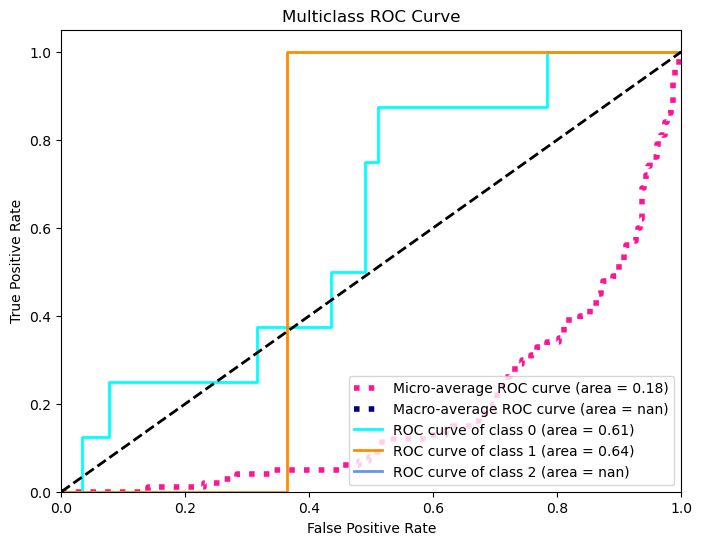

In [151]:
# to plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

def plot_multiclass_roc(y_true, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})', color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# Assuming y_true is the true labels (one-hot encoded) and y_score is the predicted probabilities for each class
y_true = label_binarize(y_true, classes=[0, 1, 2,3])  # Convert true labels to one-hot encoding if needed
# plot_multiclass_roc(y_true, y_score, n_classes=3)
plot_multiclass_roc(y_true, np.array(y_pred), n_classes=4)


### Some extra steps that I did, but didnt include in final method

In [123]:
# from sklearn.metrics import roc_auc_score
# import numpy as np

# def multiclass_roc_auc(y_true, y_pred_proba, average='macro'):
#     n_classes = 4 #y_true.shape[1]
#     roc_auc_values = []
    
#     for class_index in range(n_classes):
#         # Treat the current class as the positive class, and others as negative
#         y_true_class = y_true[:, class_index]
#         y_score_class = y_pred_proba[:, class_index]
        
#         # Check if there are positive samples for this class
#         if np.sum(y_true_class) > 0:
#             roc_auc = roc_auc_score(y_true_class, y_score_class)
#         else:
#             # Handle case where there are no positive samples
#             if average == 'micro':
#                 # For micro-average, use all true positive and false positive counts
#                 roc_auc = 0.5  # AUC of 0.5 for random classification
#             elif average == 'macro':
#                 # For macro-average, treat the class as if it had no positive samples
#                 roc_auc = 0.0  # AUC of 0.0 for no positive samples
        
#         roc_auc_values.append(roc_auc)
    
#     if average == 'macro':
#         # Macro-average: average the AUC values across all classes
#         roc_auc_values = np.mean(roc_auc_values)
#     elif average == 'micro':
#         # Micro-average: compute the weighted average of all true positive and false positive counts
#         tp = np.sum(y_true * (y_pred_proba > 0.5), axis=0)
#         fp = np.sum((1 - y_true) * (y_pred_proba > 0.5), axis=0)
#         total_tp = np.sum(tp)
#         total_fp = np.sum(fp)
#         roc_auc_values = total_tp / (total_tp + total_fp)
    
#     return roc_auc_values

# # Example usage:
# # y_true: true labels (one-hot encoded)
# # y_pred_proba: predicted probabilities for each class
# roc_auc_values = multiclass_roc_auc(test_set2.to_numpy(), np.array(y_pred), average='macro')


### Using Hyperopt

In [72]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# !pip install git+https://github.com/hyperopt/hyperopt.git


In [154]:
# learning_rate = 0.0001
# units = 128
# dropout = 0.3
# epochs = 50
# print(f"Training model with lr={learning_rate}, units={units}, dropout={dropout}")

# class_weights = calculate_class_weights_dict(get_number_of_file_each_folder(train_data_dir))
# print(f'class_weights: {class_weights}')

# model = create_model(learning_rate=learning_rate, num_dense_units=units, dropout_rate=dropout)
# model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping], class_weight=class_weights)
# loss, accuracy,precision,recall = model.evaluate(validation_generator)
# print(loss, accuracy,precision,recall)

In [ ]:
#### for the time when we want cosine similarity be inside the hypterparameters 
# def objective(params):
#     data_preparation(params['cosin_thresh'])
#     print("data_preparation done")
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     print(f"Training model with lr={params['learning_rate']}, units={params['num_dense_units']}, dropout={params['dropout_rate']}, cosin_thresh={params['cosin_thresh']}") 
#     model = create_model(learning_rate=params['learning_rate'], 
#                          num_dense_units=params['num_dense_units'], 
#                          dropout_rate=params['dropout_rate'])
#     model.fit(train_generator, 
#               epochs=params['epochs'], 
#               validation_data=validation_generator, 
#               callbacks=[early_stopping], 
#               class_weight=class_weights)
#     loss, accuracy,precision,recall = model.evaluate(validation_generator)
#     return loss

# param_grid = {
#     'cosin_thresh':hp.choice('cosin_thresh',[0.8,0.85,0.9]),
#     'learning_rate': hp.choice('learning_rate',[0.0001]), #,0.00001]),
#     'num_dense_units': hp.choice('num_dense_units',[128]),
#     'dropout_rate': hp.choice('dropout_rate',[0.3]),
#     'epochs': hp.choice('epochs',[50])
# }

# # Initialize trials object to keep track of results
# trials = Trials()

# # Run optimization
# best = fmin(objective, param_grid, algo=tpe.suggest, max_evals=1, trials=trials)

# # Print the best hyperparameters
# print("Best Hyperparameters:", best)

### Using EfficientNet as base model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define constants
img_width, img_height = 224, 224
batch_size = 32
num_classes = 4

# Define paths to the training and validation data
train_data_dir = os.path.join("dataset", "train")
valid_data_dir = os.path.join("dataset", "val")

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model and custom classification head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=5, validation_data=validation_generator)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Accuracy:", accuracy)


# Evaluation

In [106]:
test_set = pd.read_csv("test_set.csv")
test_set

,index,Mario,Frieren,Lae'zel
0,4134,0.0,0.0,0.0
1,11673,0.0,0.0,0.0
2,42508,0.0,0.0,0.0
3,61900,0.0,0.0,0.0
4,64651,1.0,0.0,0.0
...,...,...,...,...
95,9029,1.0,0.0,0.0
96,55870,0.0,0.0,0.0
97,91829,0.0,0.0,0.0
98,55147,0.0,0.0,0.0
